In [1]:
!pip install seaborn

In [2]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
import warnings
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Выполним предобработку данных и EDA 

In [3]:
np.random.seed(10)

In [4]:
path_to_data = '../input/clicks/data.csv'

In [5]:
data = pd.read_csv(path_to_data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [6]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582140e+07,1.582140e+07,1.582140e+07,1.582147e+07,1.580173e+07,1.580173e+07,1.580173e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,6.571314e+05,1.969248e-01,7.440764e-01,-3.979590e+00,2.605069e+06,1.415899e+00,5.485722e-01,-3.968883e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,2.606008e+06,2.733440e+00,1.670358e+01,1.143982e+00,5.230253e+06,8.689053e+00,1.419136e+01,1.186403e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.763740e-02,-8.588970e+00,0.000000e+00,0.000000e+00,-6.983897e-02,-9.562188e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,7.300000e+01,5.000000e-03,1.643856e-02,-4.515871e+00,9.900000e+01,4.000000e-03,1.615219e-02,-4.529519e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,3.030000e+02,1.000000e-02,3.539307e-02,-3.921164e+00,4.600000e+02,1.400000e-02,3.556666e-02,-3.928674e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,7.200000e+02,3.000000e-02,8.022935e-02,-3.421280e+00,1.236000e+03,5.000000e-02,7.546751e-02,-3.390867e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.146423e+07,1.000000e+02,6.910888e+02,3.149981e-01,1.462360e+07,1.000000e+02,6.910885e+02,4.756181e-01,1.0,1.000000e+00


Как видим, impressions состоит только из одних единиц, т.к. этот признак в себе не несет информации, можем его отбросить

In [7]:
def drop_unnecessary_data(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(['oaid_hash', 'banner_id0', 'banner_id1', 
                      'rate0', 'rate1', 'g0', 'g1',
                      'coeff_sum0', 'coeff_sum1', 'impressions'], axis=1)

In [8]:
def plot_features(features: pd.DataFrame):
    fig, axs = plt.subplots(features.shape[1] // 2, 2, figsize=(12,9))
    for i in tqdm(range(features.shape[1])):
        axs[i // 2, i % 2].hist(features.iloc[:, i])
        axs[i // 2, i % 2].set_title(str(features.columns[i]))
    plt.tight_layout()
    plt.show()

In [9]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_data = drop_unnecessary_data(data)
    cleaned_data.date_time = pd.to_datetime(cleaned_data.date_time)
    return cleaned_data

In [10]:
def analysis(data: pd.DataFrame):
    cleaned_data = clean_data(data)
    print(f'Размер датасета: {cleaned_data.shape}')
    print(f'NaN значений в датасете: {cleaned_data.isna().values.sum()}')
    print(f'Уникальных значений в столбцах: \n{cleaned_data.nunique()}')
    plot_features(cleaned_data.iloc[:, 1:])
    print(f'Матрица корреляции:')
    plot_heat_map(cleaned_data)

In [11]:
def plot_heat_map(data: pd.DataFrame):
    plt.figure(figsize=(10,7))
    cor = data.corr()
    sns.heatmap(cor, annot=True)
    plt.show()

In [12]:
cleaned_data = clean_data(data)

Размер датасета: (15821472, 7)
NaN значений в датасете: 0
Уникальных значений в столбцах: 
date_time          604712
zone_id              3444
banner_id            1633
campaign_clicks       822
os_id                  11
country_id             17
clicks                  2
dtype: int64


100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


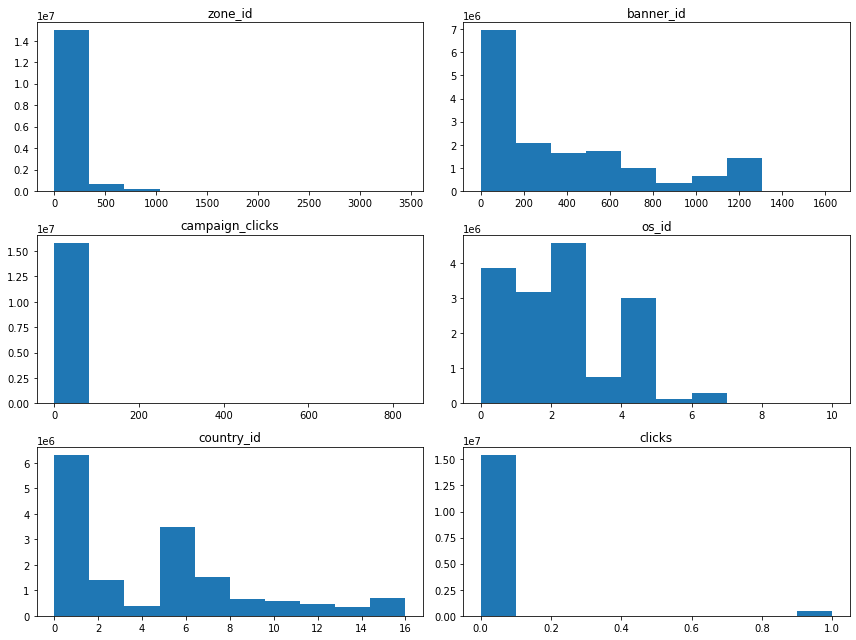

Матрица корреляции:


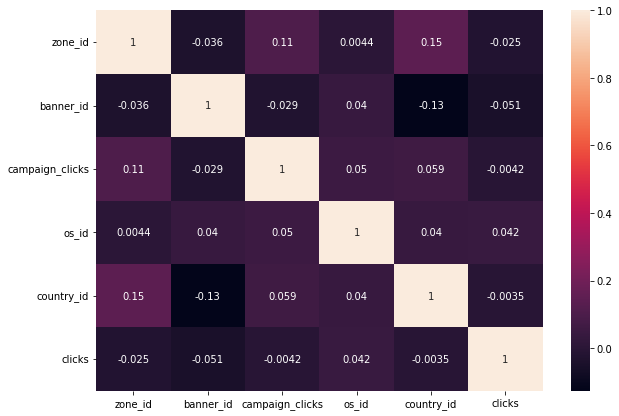

In [13]:
analysis(data)

Можем сделать следующие выводы:

* В датасете отсутствуют `NaN` значения

* Анализируя матрицу корреляции, сложно сделать однозначные выводы о фичах (нет значений, близких к $1$ или $-1$)

* Датасет содержит достаточно много несбалансированных данных - `clicks` (отличия на порядки)

* Числовые признаки не заскейлены (столбец `campaign clicks`)


После предварительного анализа датасета выполним следующие шаги:

* One Hot Encoding

* Standard Scaling (для столбца `campaign clicks`)

* Select K Best для уменьшения количества фич


После чего поделим `X` и `y` на `train` и `test` (последний день)

In [14]:
def get_X_y(data: pd.DataFrame) -> (pd.DataFrame, pd.Series):
    X = data.drop(columns=['clicks'])
    y = data.clicks
    return X, y

In [15]:
def train_test_split(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
   
    last_year = data.date.max().year
    last_month = data.date.max().month
    last_day = data.date.max().day
    latest_data = pd.Timestamp(last_year, last_month, last_day)
    test_data = data[data.date >= latest_data]
    train_data = data[data.date < latest_data]
    X_train, y_train = get_X_y(train_data)
    X_test, y_test = get_X_y(test_data)
    
    return X_train, X_test, y_train, y_test

In [16]:
def feature_engineering(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    data['date'] = data.date_time.dt.date
    data = data.drop(columns=['date_time'])
    
    scaler = StandardScaler()
    data.campaign_clicks = scaler.fit_transform(data.campaign_clicks.to_frame())
    
    X_train, X_test, y_train, y_test = train_test_split(data)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
    X_train = ohe.fit_transform(X_train)
    X_test = ohe.transform(X_test)
    
    feature_selector = SelectKBest(chi2, k=X_train.shape[1] // 3)
    X_train = feature_selector.fit_transform(X_train, y_train)
    X_test = feature_selector.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = feature_engineering(cleaned_data)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (13692494, 1924)
X_test : (2128978, 1924)
y_train : (13692494,)
y_test : (2128978,)


Будем использовать логистическую регрессию с liblinear optimizer и $L2$ регуляризацией

In [18]:
def create_model(C):
    return LogisticRegression(solver='liblinear', 
                              random_state=10,
                              penalty='l2',
                              C=C)

Подберем гиперпараметры нашей модели используя кросс-валидацию, минимизируя средний $LogLoss$

In [19]:
def cv(X_train: pd.DataFrame, y_train : pd.Series):
    log_reg_param_regularize = [0.001, 0.01, 0.1, 0.5]
    log_loss = []
    roc_auc = []
    print('Cross-validating started...')
    
    for val in log_reg_param_regularize:
        log_reg_model = create_model(val)
        cross_val = cross_validate(log_reg_model, X_train, y_train, scoring=['roc_auc', 'neg_log_loss'], cv=3)
        log_loss.append(-np.mean(cross_val['test_neg_log_loss']))
        roc_auc.append(np.mean(cross_val['test_roc_auc']))
        print(f'Regularization : {val}')
        print(f'Mean log loss : {log_loss[-1]}')
        print(f'Mean ROC AUC : {roc_auc[-1]}')
        print('--------------------')
        
    print('Cross-validating finished...')
    best_model = np.argmin(log_loss)
    print(f'Best C : {log_reg_param_regularize[best_model]}')
    
    return log_reg_param_regularize[best_model]

In [20]:
log_reg_model_cv = cv(X_train, y_train)

Cross-validating started...
Regularization : 0.001
Mean log loss : 0.1134419035682448
Mean ROC AUC : 0.6716720984775683
--------------------
Regularization : 0.01
Mean log loss : 0.11259626054157507
Mean ROC AUC : 0.687615778982348
--------------------
Regularization : 0.1
Mean log loss : 0.11283467972471657
Mean ROC AUC : 0.68882385831554
--------------------
Regularization : 0.5
Mean log loss : 0.11304888446081658
Mean ROC AUC : 0.6885746728363947
--------------------
Cross-validating finished...
Best C : 0.01


In [22]:
best_log_reg = create_model(log_reg_model_cv)
best_log_reg.fit(X_train, y_train)
model_pred = best_log_reg.predict_proba(X_test)

В качестве baseline модели воспользуемся средним по test выборке

In [27]:
model_pred

array([[0.92931893, 0.07068107],
       [0.79758797, 0.20241203],
       [0.96110244, 0.03889756],
       ...,
       [0.96302547, 0.03697453],
       [0.96379826, 0.03620174],
       [0.9981791 , 0.0018209 ]])

In [23]:
def baseline_model(y: pd.Series) -> np.array:
    y_pred_baseline = np.zeros(y.shape)
    mean_val = np.mean(y)
    y_pred_baseline.fill(mean_val)
    return y_pred_baseline

In [24]:
baseline_pred = baseline_model(y_test)

In [28]:
def get_stats(baseline_pred: np.array, model_pred: np.array, y_test: np.array):
    auc_baseline = roc_auc_score(y_test, baseline_pred)
    log_loss_baseline = log_loss(y_test, baseline_pred)
    auc_model = roc_auc_score(y_test, model_pred[:, 1])
    log_loss_model = log_loss(y_test, model_pred)
    print(f'Logistic regression model: ')
    print(f'----------------')
    print(f'Log Loss : {log_loss_model}')
    print(f'ROC AUC : {auc_model}')
    print(f'Baseline model: ')
    print(f'----------------')
    print(f'Log Loss : {log_loss_baseline}')
    print(f'ROC AUC : {auc_baseline}')

In [29]:
get_stats(baseline_pred, model_pred, y_test)

Logistic regression model: 
----------------
Log Loss : 0.13526262336511183
ROC AUC : 0.7789732645738909
Baseline model: 
----------------
Log Loss : 0.15303289904918538
ROC AUC : 0.5


Как видим, используя логистическую регрессию нам удалось превзойти бейзлайн решение для предсказания вероятности клика